In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from torch.utils.data import Dataset, DataLoader
import torch
from torch import nn
import cv2
from torchvision import transforms
import PIL
from PIL import Image
import string
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from torchvision import models

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
names = os.listdir("/kaggle/input/captcha-version-2-images/samples/")

/kaggle/input/captcha-version-2-images/samples/6n6gg.png


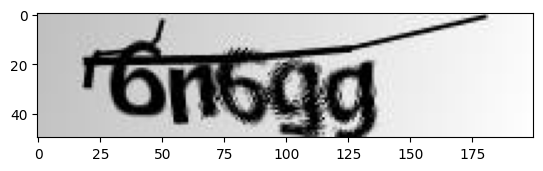

/kaggle/input/captcha-version-2-images/samples/fncnb.png


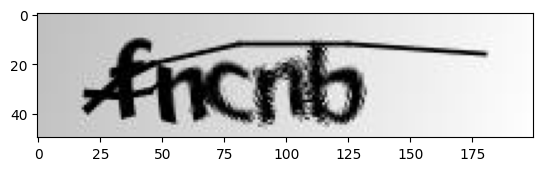

/kaggle/input/captcha-version-2-images/samples/nxf2c.jpg


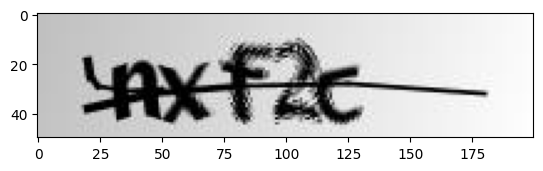

/kaggle/input/captcha-version-2-images/samples/nbwnn.png


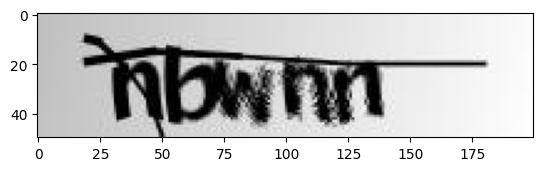

In [4]:
count = 1
for name in names:
    print(os.path.join("/kaggle/input/captcha-version-2-images/samples", name))
    image = cv2.imread(os.path.join("/kaggle/input/captcha-version-2-images/samples", name))
    plt.imshow(image)
    plt.show()
    if count > 3:
        break
    count += 1

In [5]:
all_characters = string.ascii_lowercase + string.digits
len(all_characters)

36

In [6]:
def encode(a):
    onehot = [0]*len(all_characters)
    idx = all_characters.index(a)
    onehot[idx] += 1
    return onehot

In [7]:
class Image_dataset(Dataset):
    def __init__(self, transform=None):
        super().__init__()
        
        self.transform = transform
        self.images = []
        self.labels = []
        for label in names:
            if label == "samples":
                continue
            image = os.path.join("/kaggle/input/captcha-version-2-images/samples/", label)
            self.images.append(image)
            self.labels.append(label.split(".")[0])
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, index):
        image = self.transform(Image.open(self.images[index]).convert("RGB"))
        label = []
        for character in self.labels[index]:
            label += encode(character)
        
        return image, torch.tensor(label), self.labels[index]

In [8]:
transform = transforms.Compose([
    transforms.Resize((50,200)),
    transforms.ToTensor(),
    transforms.Grayscale(num_output_channels=1)
])

In [9]:
image_dataset = Image_dataset(transform)

In [10]:
dataloader = DataLoader(image_dataset, batch_size=8, shuffle=True)

In [11]:
image, label, _ = next(iter(dataloader))
image, label, _ = next(iter(dataloader))


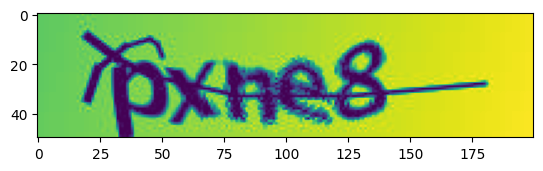

In [12]:
plt.imshow(image[0].permute(1,2,0).numpy())
plt.show()

In [13]:
label.shape

torch.Size([8, 180])

In [14]:
label

tensor([[0, 0, 0,  ..., 0, 1, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]])

In [15]:
class Model(nn.Module):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        
        self.num_classes = num_classes
        self.sequential_layer = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.Conv2d(64, 1, kernel_size=3, stride=1),
            nn.ReLU(),
        )
        
        self.linear_layer = nn.Linear(7600, num_classes)
        #self.softmax = nn.Softmax(dim=1)
    
    def forward(self, x):
        out = self.sequential_layer(x)
        out = out.view(out.shape[0], out.shape[1], -1)
        out = self.linear_layer(out)
        return out

In [16]:
model = Model(1, 180)

In [17]:
model(image).shape

torch.Size([8, 1, 180])

In [18]:
resnet = models.resnet34(pretrained=False)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [19]:
resnet.conv1 = nn.Conv2d(1, 64, kernel_size=(7,7), stride=(2,2), padding=(3,3))

In [20]:
resnet.fc = nn.Linear(512, len(all_characters) * 5)

In [21]:
epochs = 20
learning_rate = 0.001
criterion = nn.MultiLabelSoftMarginLoss()
optimizer = torch.optim.Adam(resnet.parameters(), lr=learning_rate)

In [22]:
criterion.to(device);
resnet.to(device);
model.to(device);

In [23]:
def train():
    for epoch in range(epochs):
        for images, labels, _ in dataloader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            
            output = resnet(images)
                                
            loss = criterion(output, labels)
            
            loss.backward()
            optimizer.step()
        print(f"loss: {loss.item()}")

In [24]:
train()

loss: 0.1090107187628746
loss: 0.1071966141462326
loss: 0.09305880963802338
loss: 0.08011255413293839
loss: 0.07134012877941132
loss: 0.05785413831472397
loss: 0.05764935165643692
loss: 0.045463621616363525
loss: 0.03897492215037346
loss: 0.04462862014770508
loss: 0.0259859561920166
loss: 0.02331274002790451
loss: 0.010286148637533188
loss: 0.015247700735926628
loss: 0.008065307512879372
loss: 0.007437075953930616
loss: 0.009533200412988663
loss: 0.0082036592066288
loss: 0.00807599350810051
loss: 0.0028100961353629827


In [25]:
predicted_captcha = model(image.to(device))

In [26]:
torch.argmax(predicted_captcha[0])

tensor(87, device='cuda:0')

In [27]:
all_characters

'abcdefghijklmnopqrstuvwxyz0123456789'

In [32]:
image, ohe, truth = next(iter(dataloader))

In [33]:
for im, truth in zip(image, truth):
    im = im.unsqueeze(0)
    pred = resnet(im.to(device))
    c1 = all_characters[np.argmax(pred.squeeze().cpu().tolist()[0:len(all_characters)])]
    c2 = all_characters[np.argmax(pred.squeeze().cpu().tolist()[len(all_characters):len(all_characters) * 2])]
    c3 = all_characters[np.argmax(pred.squeeze().cpu().tolist()[len(all_characters) * 2:len(all_characters) * 3])]
    c4 = all_characters[np.argmax(pred.squeeze().cpu().tolist()[len(all_characters) * 3:len(all_characters) * 4])]
    c5 = all_characters[np.argmax(pred.squeeze().cpu().tolist()[len(all_characters) * 4:len(all_characters) * 5])]
    
    label = f"{c1}{c2}{c3}{c4}{c5}"
    print(f"predicted: {label} --- ground truth: {truth}")
    

predicted: b5dn4 --- ground truth: b5dn4
predicted: denen --- ground truth: deneb
predicted: 3enyn --- ground truth: 3eny7
predicted: 75f54 --- ground truth: x5f54
predicted: dnxcc --- ground truth: gfxcc
predicted: enn7n --- ground truth: e667x
predicted: mpmyn --- ground truth: mpmy5
predicted: p2x7x --- ground truth: p2x7x
